Assignment 4 --

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from matplotlib import pyplot as plt
from torchvision import utils

'''
STEP 1: LOADING DATASET
'''
 
train_dataset = dsets.CIFAR10(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.CIFAR10(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

 
'''
STEP 2: MAKING DATASET ITERABLE
'''
 
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
 
'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self, pooling="max"):
        super(CNNModel, self).__init__()
        
        self.pool = pooling
        
        print('Pooling method used is - ',self.pool)
                   
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)  
        self.relu1 = nn.ReLU()
         
        # Pooling - Max or Avg
        if self.pool == "max":
          # Max pool
          self.pooling = nn.MaxPool2d(kernel_size=2) 
        else:
          # Avg pool
          self.pooling = nn.AvgPool2d(kernel_size=2)
      
        # Convolution 2max
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.relu2 = nn.ReLU()
      
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(64*6*6, 10) 
        
  
    
    def forward(self, x):
        
        # Convolution 1
        out = self.cnn1(x) 
        out = self.relu1(out) 
         
        # Max or Avg pooling
        out = self.pooling(out)
         
        # Convolution 2 
        out = self.cnn2(out) 
        out = self.relu2(out) 
         
        # Max or Avg pooling
        out = self.pooling(out)

        out = out.view(out.size(0), -1)   
 
        # Linear function (readout)
        out = self.fc1(out)
         
        return out
 
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
 
model = CNNModel().float()

 
if torch.cuda.is_available():
    model.cuda()
 
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()
 
 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
'''
STEP 7: TRAIN THE MODEL
'''
iter = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))
            
   

Files already downloaded and verified
Pooling method used is -  max


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 500. Loss: 2.0434141159057617. Accuracy: 26
Iteration: 1000. Loss: 1.85190749168396. Accuracy: 35
Iteration: 1500. Loss: 1.6719717979431152. Accuracy: 38
Iteration: 2000. Loss: 1.5508860349655151. Accuracy: 45
Iteration: 2500. Loss: 1.4033410549163818. Accuracy: 47
Iteration: 3000. Loss: 1.4879132509231567. Accuracy: 48
Iteration: 3500. Loss: 1.2471907138824463. Accuracy: 50
Iteration: 4000. Loss: 1.3360182046890259. Accuracy: 51
Iteration: 4500. Loss: 1.403914451599121. Accuracy: 52
Iteration: 5000. Loss: 1.2009496688842773. Accuracy: 53
Iteration: 5500. Loss: 1.402686357498169. Accuracy: 53
Iteration: 6000. Loss: 1.3218142986297607. Accuracy: 55


In [0]:
# Visualizing the Kernels

def plot_kernels(tensor, n_cols):
    n_kernels = tensor.shape[0]
    n_rows = 1+ n_kernels // n_cols
    fig = plt.figure(figsize=(n_cols,n_rows))
    for i in range(n_kernels):
        ax1 = fig.add_subplot(n_rows,n_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()
    

# Visualizing the output images of Convolutional Layer

def plot_images(tensor, n_cols=10):
  n_kernels = tensor.shape[0]
  n_rows = 1+ n_kernels // n_cols
  fig = plt.figure(figsize=(n_cols,n_rows))
  for i in range(n_kernels):
    ax1 = fig.add_subplot(n_rows,n_cols,i+1)
    ax1.imshow(tensor[i], cmap='gray')
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()


Kernel Visualization
torch.Size([32, 3, 3, 3])


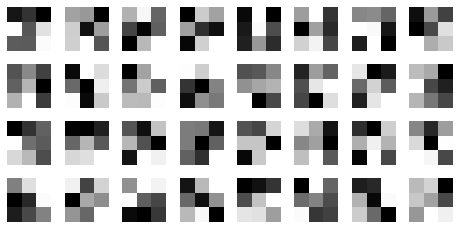

torch.Size([64, 32, 4, 4])


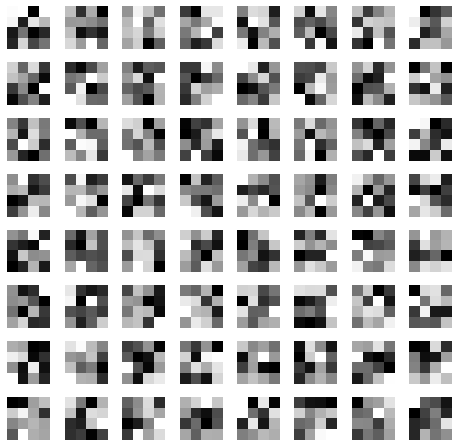

In [0]:
# Kernel Visualization
print("Kernel Visualization")
filters = model.modules()
model_layers = [i for i in model.children()]
first_layer = model_layers[0]
second_layer = model_layers[3]

first_kernels = first_layer.weight.data.clone()
print(first_kernels.shape)
plot_kernels(first_kernels, 8)


second_kernels = second_layer.weight.data.clone()
print(second_kernels.shape)
plot_kernels(second_kernels, 8)


Image Visualization
torch.Size([32, 30, 30])
Convolutional Output Layer - 1


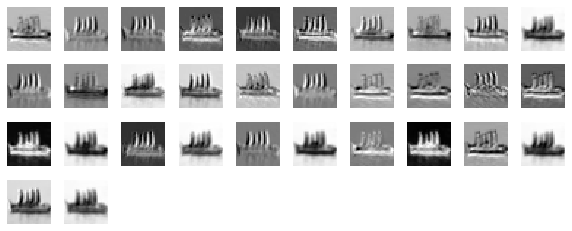

torch.Size([32, 15, 15])


In [0]:
# Image Visualization
print("Image Visualization")
for images, labels in test_loader:
  images = Variable(images.view(-1, 3*32*32))
  image = images[0].view(1, 3, 32, 32).cuda()
      
out = model.cnn1(image)
out = out.squeeze()

# show images
print(out.shape)
print('Convolutional Output Layer - 1')
plot_images(out.data.cpu().numpy())
      
out = model.pooling(model.relu1(out))
           
print(out.shape)
#out = model.cnn2(out)
#out = out.squeeze()
      
#print('Convolutional Output Layer - 2')
#plot_images(out.data().cpu().numpy())

In [0]:
# Max Pooling works better with CIFAR10
  Pooling method used is -  avg
Iteration: 500. Loss: 2.0478649139404297. Accuracy: 28
Iteration: 1000. Loss: 1.9877116680145264. Accuracy: 34
Iteration: 1500. Loss: 1.6705795526504517. Accuracy: 36
Iteration: 2000. Loss: 1.7351396083831787. Accuracy: 40
Iteration: 2500. Loss: 1.527145266532898. Accuracy: 41
Iteration: 3000. Loss: 1.707576036453247. Accuracy: 39
Iteration: 3500. Loss: 1.6119221448898315. Accuracy: 45
Iteration: 4000. Loss: 1.4649723768234253. Accuracy: 45
Iteration: 4500. Loss: 1.4537060260772705. Accuracy: 48
Iteration: 5000. Loss: 1.4961973428726196. Accuracy: 49
Iteration: 5500. Loss: 1.3070504665374756. Accuracy: 49
Iteration: 6000. Loss: 1.318798542022705. Accuracy: 50
      
  Pooling method used is -  max
Iteration: 500. Loss: 1.9730092287063599. Accuracy: 29
Iteration: 1000. Loss: 1.7490320205688477. Accuracy: 38
Iteration: 1500. Loss: 1.6110621690750122. Accuracy: 41
Iteration: 2000. Loss: 1.9844233989715576. Accuracy: 44
Iteration: 2500. Loss: 1.3778960704803467. Accuracy: 47
Iteration: 3000. Loss: 1.5982863903045654. Accuracy: 48
Iteration: 3500. Loss: 1.3600651025772095. Accuracy: 51
Iteration: 4000. Loss: 1.5198498964309692. Accuracy: 52
Iteration: 4500. Loss: 1.332473635673523. Accuracy: 52
Iteration: 5000. Loss: 1.2608916759490967. Accuracy: 55
Iteration: 5500. Loss: 1.230204701423645. Accuracy: 53
Iteration: 6000. Loss: 1.2494070529937744. Accuracy: 56
      
